In [3]:
import os
import sys
sys.path.append("/home/ubuntu/anaconda3/lib/python3.6/site-packages")
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as intp
import sys
import time
from matplotlib import animation, rc
from matplotlib.pyplot import figure
import hdf5storage as h5mat
import h5py as h5
import sklearn.model_selection
import pydot
from matplotlib.pyplot import figure

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6334668148213383133
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5325000535036971211
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [7]:
# directory info
model_directory = '/home/ubuntu/CS230_project/velocitynn/data/layers/models/'
model_file = '600x200x10000_flat_v0.mat'
model_path = model_directory+model_file
shot_directory = '/home/ubuntu/CS230_project/velocitynn/data/layers/shots/'
shot_file = '600x200x10000_flat_1shot_v0.mat'
shot_path=shot_directory+shot_file
filepath=os.getcwd()


In [8]:
# Reading all the shot data
dout = h5.File(shot_path,'r')

# Reading all the velocity models
dout1 = h5.File(model_path,'r')

depth_sample = 10
vel_top = 1500
time_max = 0.8
time_sample = 2e-3
time_interp = np.arange(depth_sample/vel_top, time_max,time_sample)

num_shots = 1000
shot_shape_offset,shot_shape_time  = dout['shot_model_1'].shape
shot_data =  np.zeros((shot_shape_offset,shot_shape_time,num_shots)) #offset, time, samples
vel_rms_data = np.zeros((time_interp.shape[0],num_shots))

for i in range(num_shots):
    shot_data[:,:,i] = dout['shot_model_'+str(i)]
    vp_dummy = dout1['vp'+str(i)]
    vp_dummy = np.transpose(vp_dummy[:,:])
    vp_trace = vp_dummy[:,int(vp_dummy.shape[1]/2)]
    time_diff = depth_sample/vp_trace
    time = np.cumsum(time_diff)
    vp = intp.interp1d(time, vp_trace)(time_interp)
    vel_rms_data[:,i] = np.sqrt(np.cumsum(vp**2)/np.arange(1,vp.shape[0]+1,1))
    
del dout, dout1, vp_dummy, vp_trace, time, vp

print('n_x:',shot_data.shape)
print('n_y:', vel_rms_data.shape)

n_x: (599, 433, 1000)
n_y: (397, 1000)


In [9]:
# Import keras modules for CNN

from keras import layers, initializers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')


Using TensorFlow backend.


In [10]:
# Normalize input and output data
shot_data_normalize = (shot_data - np.min(shot_data, axis =(0,1)))/(np.max(shot_data, axis =(0,1))-np.min(shot_data, axis =(0,1)))
vel_rms_data_normalize = (vel_rms_data - np.min(vel_rms_data, axis=0))/(np.max(vel_rms_data, axis=0) - np.min(vel_rms_data, axis=0))

# Reshape
vel_rms_data_normalize = vel_rms_data_normalize.transpose()
shot_data_normalize = np.swapaxes(shot_data_normalize.transpose(),1,2 )

# Split data into train and test set
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(shot_data_normalize,vel_rms_data_normalize, test_size=0.2, random_state=1)

# X_test, X_val, Y_test, Y_val = sklearn.model_selection.train_test_split(X_test, Y_test, test_size=0.5, random_state=1)

# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 800
number of test examples = 200
X_train shape: (800, 599, 433, 1)
Y_train shape: (800, 397)
X_test shape: (200, 599, 433, 1)
Y_test shape: (200, 397)


In [11]:
# Building neural network in Keras 
given_seed = 3 # For repeatibility

def velocitynet(input_shape):
    """
    Implementation of the VelocityNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input shot gather 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
#     X = ZeroPadding2D((3, 3))(X_input)
    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (7, 7), strides=(2, 2), name='conv0', 
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (6, 6), strides=(2, 2), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool1')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (6, 6), strides=(2, 2), name='conv2',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn2')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((8, 8), strides=(4,4),name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(397, activation='sigmoid', name='fc')(X)
    X = Activation('relu')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='velModel')

    return model
    ### END CODE HERE ###

In [12]:
# Create the model
velModel = velocitynet(X_train.shape[1:])


In [56]:
# Summary and plot of the model

velModel.summary()


plot_model(velModel)
SVG(model_to_dot(velModel).create(prog='dot', format='svg'))
plot_model(velModel, to_file='/Figures/model_plot_08Nov_Vishal.png', show_shapes=True, show_layer_names=True)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 599, 433, 1)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 297, 214, 16)      800       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 297, 214, 16)      64        
_________________________________________________________________
activation_22 (Activation)   (None, 297, 214, 16)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 148, 107, 16)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 72, 51, 32)        18464     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 72, 51, 32)        128       
__________

In [13]:
# Compile the model with optimization algorithm, loss function
# from keras.utils import multi_gpu_model
# velModel = multi_gpu_model(velModel, gpus=1)
velModel.compile('adam', 'mean_squared_error', metrics=['accuracy'])

In [14]:
# Start the training
history = velModel.fit(X_train, Y_train, validation_split=0.25, epochs=100, batch_size=32)

Train on 600 samples, validate on 200 samples
Epoch 1/100
600/600 [==============================] - 40s 66ms/step - loss: 0.0521 - acc: 0.0000e+00 - val_loss: 0.0140 - val_acc: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 3s 4ms/step - loss: 0.0033 - acc: 0.0000e+00 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 3/100
600/600 [==============================] - 3s 4ms/step - loss: 0.0016 - acc: 0.0000e+00 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 4/100
600/600 [==============================] - 3s 4ms/step - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 5/100
600/600 [==============================] - 3s 4ms/step - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 6/100
600/600 [==============================] - 3s 4ms/step - loss: 0.0010 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 7/100
600/600 [==============================] - 3s 4ms/step - loss: 9.6137e-04 - acc: 0.0000e+00 - 

Epoch 59/100
600/600 [==============================] - 3s 4ms/step - loss: 2.5342e-04 - acc: 1.0000 - val_loss: 6.4931e-04 - val_acc: 1.0000
Epoch 60/100
600/600 [==============================] - 3s 4ms/step - loss: 2.3924e-04 - acc: 1.0000 - val_loss: 6.6287e-04 - val_acc: 1.0000
Epoch 61/100
600/600 [==============================] - 3s 4ms/step - loss: 2.4869e-04 - acc: 1.0000 - val_loss: 6.4250e-04 - val_acc: 1.0000
Epoch 62/100
600/600 [==============================] - 3s 4ms/step - loss: 2.3981e-04 - acc: 1.0000 - val_loss: 6.1102e-04 - val_acc: 1.0000
Epoch 63/100
600/600 [==============================] - 3s 4ms/step - loss: 2.3854e-04 - acc: 1.0000 - val_loss: 7.0721e-04 - val_acc: 1.0000
Epoch 64/100
600/600 [==============================] - 3s 4ms/step - loss: 2.2511e-04 - acc: 1.0000 - val_loss: 7.2351e-04 - val_acc: 1.0000
Epoch 65/100
600/600 [==============================] - 3s 4ms/step - loss: 2.2347e-04 - acc: 1.0000 - val_loss: 6.4237e-04 - val_acc: 1.0000
Epoch 

In [15]:
# Testing and evaluating the model
preds = velModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

200/200 [==============================] - 1s 3ms/step

Loss = 0.0007005325169302523
Test Accuracy = 1.0


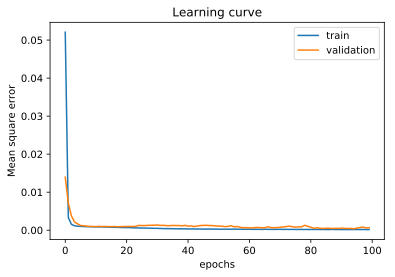

In [16]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Mean square error')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

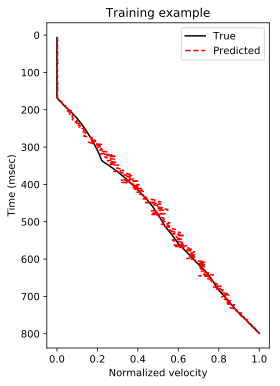

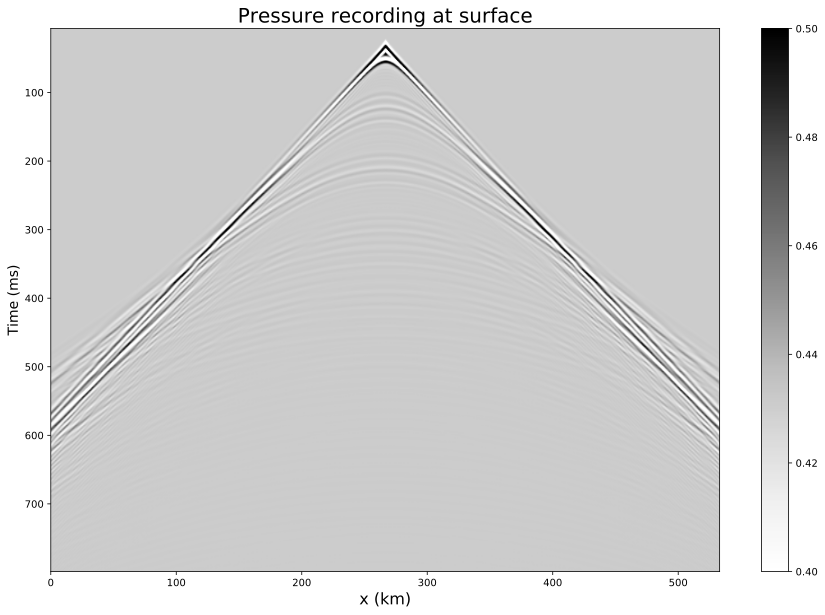

In [19]:
# Plot some of the training examples - true vs trained
sample_number = 60
X_train_sample = X_train[sample_number,:,:,:]
X_train_sample = np.expand_dims(X_train_sample, axis=0)
Y_train_sample = Y_train[sample_number,:]
Y_train_sample_predict = velModel.predict(X_train_sample)

figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
line1, = plt.plot(Y_train_sample, time_interp*1e3, '-k')
line2, = plt.plot(Y_train_sample_predict[0,:], time_interp*1e3, '--r')
plt.legend((line1, line2), ('True', 'Predicted'))
plt.xlabel('Normalized velocity')
plt.ylabel('Time (msec)')
plt.title('Training example')
plt.gca().invert_yaxis()
# plt.savefig('/Figures/training_example_velocity_08Nov.png', bbox_inches='tight')
plt.show()

# clip=0.65;
p_el = np.reshape(X_train[sample_number,:,:,:], (599,433)).transpose()
# vmin=np.min(p_el)*clip;
# vmax=np.max(p_el)*clip;
# fig, ax = plt.subplots(figsize=(10,10))
figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=0.4, 
               vmax=0.5, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper', extent=[0,533,np.max(time_interp)*1e3,np.min(time_interp)*1e3])
plt.title('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.colorbar()
plt.show()
# plt.savefig('/Figures/training_example_seismic_08Nov.png', bbox_inches='tight')

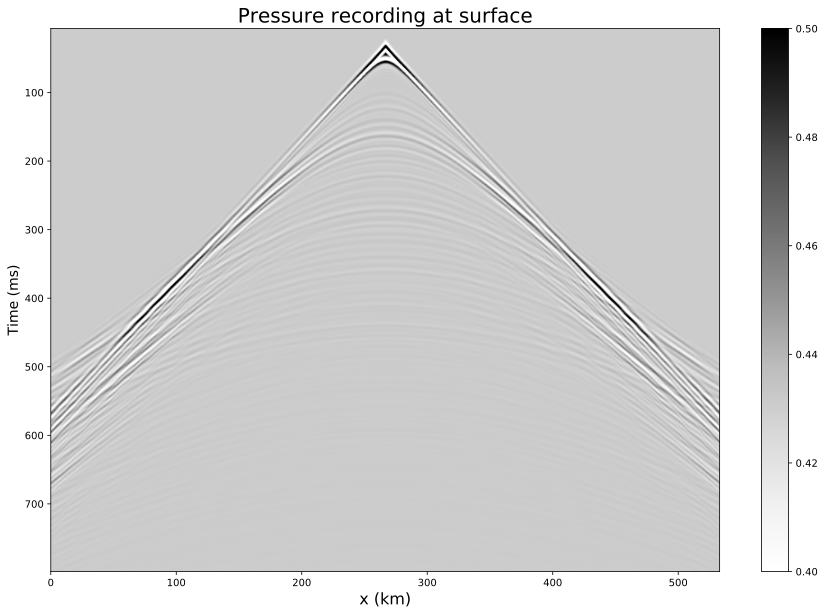

In [20]:
# Plot some of test examples
sample_number = 5
X_test_sample = X_test[sample_number,:,:,:]
X_test_sample = np.expand_dims(X_test_sample, axis=0)
Y_test_sample = Y_test[sample_number,:]
Y_test_sample_predict = velModel.predict(X_test_sample)

figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
line1, =plt.plot(Y_test_sample, time_interp*1e3, '-k')
line2, = plt.plot(Y_test_sample_predict[0,:], time_interp*1e3, '--r')
plt.legend((line1, line2), ('True', 'Predicted'))
plt.title('Test example')
plt.xlabel('Normalized velocity')
plt.ylabel('Time (sec)')
plt.gca().invert_yaxis()
# plt.savefig('Figures/test_example_velocity_08Nov.png', bbox_inches='tight')
plt.show()

# clip=0.65;
p_el = np.reshape(X_test[sample_number,:,:,:], (599,433)).transpose()
# vmin=np.min(p_el)*clip;
# vmax=np.max(p_el)*clip;
# fig, ax = plt.subplots(figsize=(10,10))
figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=0.4, 
               vmax=0.5, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper', extent=[0,533,np.max(time_interp)*1e3,np.min(time_interp)*1e3])
plt.title('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.colorbar()
plt.show()
# plt.savefig('Figures/test_example_seismic_08Nov.png', bbox_inches='tight')